In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from matplotlib import pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

In [2]:
def fit_linear_reg(X,Y):
    from sklearn import linear_model
    from sklearn.metrics import mean_squared_error
    #Fit linear regression model and return RSS and R squared values
    model_k = linear_model.LinearRegression(fit_intercept = True)
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    return RSS, R_squared

def forward_stepwise(X, Y):
    import itertools
    #Initialization variables
    k = X.shape[1]

    remaining_features = list(X.columns.values)
    features = []
    RSS_list, R_squared_list = [np.inf], [np.inf] #Due to 1 indexing of the loop...
    features_list = dict()

    for i in range(1,k+1):
        best_RSS = np.inf

        for combo in itertools.combinations(remaining_features,1):

                RSS = fit_linear_reg(X[list(combo) + features],Y)   #Store temp result 

                if RSS[0] < best_RSS:
                    best_RSS = RSS[0]
                    best_R_squared = RSS[1] 
                    best_feature = combo[0]

        #Updating variables for next loop
        features.append(best_feature)
        remaining_features.remove(best_feature)

        #Saving values for plotting
        RSS_list.append(best_RSS)
        R_squared_list.append(best_R_squared)
        features_list[i] = features.copy()
    
    table = np.array([[i, features_list[i], RSS_list[i], RSS_list[i-1]-RSS_list[i]] for i in range(1,k+1)])
    subsets = pd.DataFrame({'no_features': table[:,0], 'features': table[:,1], 'RSS': table[:,2], 'distance': table[:,3]})
    print('Forward stepwise subset selection')
#     print('Number of features |', 'Features |', 'RSS')
    print(subsets)

In [3]:
from matplotlib.patches import Ellipse, Rectangle

def get_cov_ellipse(cov, centre, nstd, eig = False, **kwargs):
    """
    Return a matplotlib Ellipse patch representing the covariance matrix
    cov centred at centre and scaled by the factor nstd.

    """

    # Find and sort eigenvalues and eigenvectors into descending order
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = eigvecs[:,0][0], eigvecs[:,0][1]
    theta = np.arctan2(vy, vx)

    # Width and height of ellipse to draw
    width, height = 2 * nstd * np.sqrt(eigvals)
    if eig:
        return Ellipse(xy=centre, width=width, height=height,
                   angle=np.degrees(theta), **kwargs), eigvals, eigvecs
    else: 
        return Ellipse(xy=centre, width=width, height=height,
                   angle=np.degrees(theta), **kwargs)
    
def simultaneous_ci_2d(IC_1, IC_2, **kwargs):
    height = IC_2[1]-IC_2[0]
    width = IC_1[1]-IC_1[0]
    point = [IC_1[0],IC_2[0]]
    return Rectangle(point, width, height, **kwargs)

### 7.20
**Sử dụng dữ liệu battery-failure ở bảng 7.5, hồi quy $\ln{(Y)}$ trên thành phần chính thứ nhất của các biến dự đoán $z_1,z_2,...,z_5$ (Xem Section 8.3). So sánh kết quả với mô hình được fit thu được ở bài tập 7.19(a).**

In [4]:
path_20 = 'T7-5.txt'
data_20 = pd.read_table(path_20, delim_whitespace=True, header=None)
data_20.columns = ['Z1', 'Z2', 'Z3', 'Z4', 'Z5', 'Y']

X = data_20.drop('Y', axis=1)
y = data_20['Y']

print(">> Data: \n", data_20) 

>> Data: 
        Z1    Z2     Z3  Z4    Z5    Y
0   0.375  3.13   60.0  40  2.00  101
1   1.000  3.13   76.8  30  1.99  141
2   1.000  3.13   60.0  20  2.00   96
3   1.000  3.13   60.0  20  1.98  125
4   1.625  3.13   43.2  10  2.01   43
5   1.625  3.13   60.0  20  2.00   16
6   1.625  3.13   60.0  20  2.02  188
7   0.375  5.00   76.8  10  2.01   10
8   1.000  5.00   43.2  10  1.99    3
9   1.000  5.00   43.2  30  2.01  386
10  1.000  5.00  100.0  20  2.00   45
11  1.625  5.00   76.8  10  1.99    2
12  0.375  1.25   76.8  10  2.01   76
13  1.000  1.25   43.2  10  1.99   78
14  1.000  1.25   76.8  30  2.00  160
15  1.000  1.25   60.0   0  2.00    3
16  1.625  1.25   43.2  30  1.99  216
17  1.625  1.25   60.0  20  2.00   73
18  0.375  3.13   76.8  30  1.99  314
19  0.375  3.13   60.0  20  2.00  170


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_scaled = (X - X.mean(axis = 0))/X.std(axis = 0, ddof = 1)

pca = PCA(n_components=1)
X_pca = pca.fit_transform(X_scaled)
print(pca.components_)

[[-0.60642416  0.39013152  0.63569492  0.27553455  0.00445201]]


In [6]:
def regression_model(X, y):
    z = np.concatenate([np.ones([X.shape[0],1]), X], axis=1)
    zz = (z.T).dot(z)
    zy = (z.T).dot(y)
    beta = np.linalg.inv(zz).dot(zy)
    y_hat = z.dot(beta)
    epsilon = y - y_hat
    
    y_mean = y.mean()
    R2 = (y_hat - y_mean).T.dot((y_hat - y_mean))/(y - y_mean).T.dot((y - y_mean))
    
    print(">> Least square estimates: beta = \n", beta)
    print("\n>> The vector of fitted (predicted) values: y_hat = \n", y_hat)
    print("\n>> The residuals: epsilon = \n", np.array(epsilon))
    print("\n>> The coefficient of determination: R2 = ", R2)

In [7]:
regression_model(X_pca, np.log(y))

>> Least square estimates: beta = 
 [3.99978876 0.16129133]

>> The vector of fitted (predicted) values: y_hat = 
 [4.21180656 4.14911605 3.99396477 3.99248101 3.70997155 3.86512283
 3.86660659 4.2730997  3.91998754 4.01047115 4.34184455 4.01393206
 4.10734208 3.75422991 4.06675811 3.8218651  3.71438782 3.78202301
 4.27795799 4.12280671]

>> The residuals: epsilon = 
 [ 0.40331395  0.79964384  0.57038342  0.83583272  0.05122856 -1.09253411
  1.36983537 -1.97051461 -2.82137525  1.94536622 -0.53518206 -3.32078488
  0.22339126  0.60247891  1.00841571 -2.72325281  1.66089058  0.50843643
  1.471435    1.01299172]

>> The coefficient of determination: R2 =  0.015017645625395865


Từ tính toán ở trên, ta có
* Phương trình hồi quy tuyến tính của $\ln(Y)$ trên thành phần chính thứ nhất của các biến dự đoán $x_1^* = -0.60642416z_1 + 0.39013152z_2 + 0.63569492z_3 + 0.27553455z_4 + 0.00445201z_5$ là:  $\ln(Y)=3.99978876 +0.16129133x_1^*$.
* $R^2 = 0.015$.


Ta có kết quả của bài tập 7.19(a) như sau:

* Phương trình hồi quy tuyến tính từ bộ tập con các biến phù hợp là: $\ln(Y)=2.756 -0.322z_1+0.114z_3$.
* $R^2 = 0.60$

Từ đây, ta thấy rằng $R^2$ của $\ln(Y)$ trên thành phần chính khá thấp do đó tính giải thích được thấp hơn rất nhiều so với kết quả từ bài tập 7.19(a) với $R^2 = 0.6$.

### 7.25
**Amitriptyline được một số bác sĩ kê đơn như thuốc chống trầm cảm. Tuy nhiên, cũng có những tác dụng phụ được phỏng đoán liên quan đến việc sử dụng thuốc như: nhịp tim không đều, huyết áp bất thường và sóng không đều trên điện tâm đồ, cũng nhiều triệu chứng khác. Dữ liệu thu được trên 17 bệnh nhân nhập viện sau khi dùng quá liều amitriptyline được đưa ra trong bảng 7.6. Hai biến phản hồi là**

* $Y_1$ **= Tổng mức TCAD trong huyết tương (TOT)**
* $Y_2$ **= Lượng amitriptyline có trong mức TCAD trong huyết tương (AMI)**

**5 biến dự đoán là**

* $Z_1$ **= Giới tính: 1 nếu là nữ, 0 nếu là nam (GEN)**
* $Z_2$ **= Lượng antidepressants dùng tại thời điểm quá liều (AMT)**
* $Z_3$ **= Phép đo sóng PR (PR)**
* $Z_4$ **= Huyết áp tâm trương (DIAP)**
* $Z_5$ **= Phép đo sóng QRS (QRS)**

In [8]:
path_25 = 'T7-6.txt'
data_25 = pd.read_table(path_25, delim_whitespace=True, header=None)
data_25.columns = ['Y1', 'Y2', 'Z1', 'Z2', 'Z3', 'Z4', 'Z5']

X = data_25.drop(['Y1', 'Y2'], axis=1)
y = data_25[['Y1', 'Y2']]

print(">> Data: \n", data_25) 

>> Data: 
       Y1    Y2  Z1    Z2   Z3  Z4   Z5
0   3389  3149   1  7500  220   0  140
1   1101   653   1  1975  200   0  100
2   1131   810   0  3600  205  60  111
3    596   448   1   675  160  60  120
4    896   844   1   750  185  70   83
5   1767  1450   1  2500  180  60   80
6    807   493   1   350  154  80   98
7   1111   941   0  1500  200  70   93
8    645   547   1   375  137  60  105
9    628   392   1  1050  167  60   74
10  1360  1283   1  3000  180  60   80
11   652   458   1   450  160  64   60
12   860   722   1  1750  135  90   79
13   500   384   0  2000  160  60   80
14   781   501   0  4500  180   0  100
15  1070   405   0  1500  170  90  120
16  1754  1520   1  3000  180   0  129


**(a) Thực hiện phân tích hồi quy bằng cách sử dụng biến phản hồi thứ 1 $Y_1$.**

*    **(i) Đề xuất và fit một xấp xỉ mô hình hồi quy tuyến tính.**

*    **(ii) Phân tích residuals.**

*    **(iii) Xây dựng khoảng dự đoán 95% cho tổng mức TCAD với $z_1=1, z_2 = 1200, z_3 = 140, z_4 = 70$ và $z_5 = 85$.**

In [9]:
forward_stepwise(X, y['Y1'])

Forward stepwise subset selection
  no_features              features             RSS       distance
0           1                  [Z2]  2680807.253741            inf
1           2              [Z2, Z1]  1800356.362461   880450.89128
2           3          [Z2, Z1, Z3]  1459222.333278  341134.029183
3           4      [Z2, Z1, Z3, Z4]  1178249.015138   280973.31814
4           5  [Z2, Z1, Z3, Z4, Z5]   870008.310486  308240.704652


Từ phương pháp hồi quy từng bước, ta có thể chọn ra `[Z1, Z2, Z3]` là các thành phần quan trọng của dữ liệu trên biến phản hồi thứ 1.

Khi đó, ta đi kiểm định giả thuyết $H_0: \beta_4 = \beta_5 = 0$.

Giả sử $H_0$ đúng, ta xét thống kê
$$\dfrac{(SS_{res}(Z_1) - SS_{res}(Z))/(r-q)}{s^2} \sim \mathcal{F}_{r-q, n-r-1}(\alpha)$$

Ta tiến hành kiểm định như sau

In [10]:
def likelihood_ratio_test(X, y, features, alpha):
    import statsmodels.api as sm
    
    n, r = X.shape
    q = len(features)
    
    _X = sm.add_constant(X)
    X1 = X[features]
    X2 = X.drop(features, axis=1)
    _X1 = sm.add_constant(X1)
    
    model = sm.OLS(y, _X).fit()
    beta_hat = model.params.to_numpy()
    
    model1 = sm.OLS(y, _X1).fit()
    beta1_hat = model1.params.to_numpy()
    
    SS_Z1 = (y - _X1.dot(beta1_hat)).dot((y - _X1.dot(beta1_hat)))
    
    SS_Z = (y - _X.dot(beta_hat)).dot((y - _X.dot(beta_hat)))
    
    s_square = SS_Z/(n-r-1)
    
    c = ((SS_Z1 - SS_Z)/(r-q))/s_square
    
    critical_value = stats.f.ppf(q=1-alpha, dfn=r-q, dfd=n-r-1)
    
    print(f'>> Statistic = {c}')
    print(f'>> F-distribution degree of freedom = {r-q}, {n-r-1}')
    print(f'>> Critical value = {critical_value}')
    
    if c > critical_value:
        print('>> Conclusion : Reject H_0')
    else:
        print('>> conclusion : Accept H_0')

In [11]:
likelihood_ratio_test(X, y['Y1'], ['Z1', 'Z2', 'Z3'], 0.05)

>> Statistic = 3.7248806549301703
>> F-distribution degree of freedom = 2, 11
>> Critical value = 3.9822979570944836
>> conclusion : Accept H_0


Từ kết quả trên, ta không đủ cơ sở để bác bỏ giả thuyết $H_0$ với mức ý nghĩa $\alpha = 0.05$. Khi đó, các biến $Z_4, Z_5$ không có ảnh hưởng đến kết quả hồi quy.

In [12]:
mod = smf.ols('Y1 ~ Z1 + Z2 + Z3', data=data_25)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     Y1   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     18.55
Date:                Wed, 02 Jun 2021   Prob (F-statistic):           5.57e-05
Time:                        13:27:20   Log-Likelihood:                -120.68
No. Observations:                  17   AIC:                             249.4
Df Residuals:                      13   BIC:                             252.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1327.9887    817.440     -1.625      0.1

Từ bảng trên, ta có được phương trình hồi quy $\hat{y}_1 = -1327.9887 + 558Z_1 + 0.2583Z_2 + 8.5783Z_3$

In [13]:
def prediction_interval(X, y, z0, beta, alpha, name_y, confidence = True, return_value = False):
    z0 = np.insert(z0, 0, 1, axis=0)
    x = z0.dot(beta)
    
    n, r = X.shape
    
    t = stats.t.ppf(1-alpha/2, n-r-1)
    z = np.concatenate([np.ones([X.shape[0],1]), X], axis=1)
    zz = (z.T).dot(z)
    y_hat = z.dot(beta)
    epsilon = y - y_hat
    s2 = (epsilon.dot(epsilon))/(n-r-1)
    
    c1 = t*np.sqrt(s2*(z0.dot(np.linalg.inv(zz).dot(z0))))
    c2 = t*np.sqrt(s2*(1+z0.dot(np.linalg.inv(zz).dot(z0))))
    
    if confidence:
        print(">> {}% confidence interval for the mean {} at {} is :\n ({}, {})".format((1-alpha)*100, name_y, z0, x-c1, x+c1))
    print("\n>> {}% prediction interval for {} with conditions {} is :\n ({}, {})".format((1-alpha)*100, name_y, z0, x-c2, x+c2))
    if return_value:
        return np.array([x-c1, x+c1]), np.array([x-c2, x+c2]) 

In [14]:
beta1 = res.params
z0 = np.array([1, 1200, 140])
alpha = 0.05

In [15]:
prediction_interval(X[['Z1', 'Z2', 'Z3']], y['Y1'], z0, beta1, alpha, "Total TCAD", confidence=False)


>> 95.0% prediction interval for Total TCAD with conditions [   1    1 1200  140] is :
 (-62.409078953467315, 1544.7601170333667)


Kết quả dưới đây dùng để phục vụ cho câu (c).

In [16]:
mod1 = smf.ols('Y1 ~ Z1 + Z2', data=data_25)
res1 = mod1.fit()
beta1 = res1.params
z0 = np.array([1, 1200])
_, IC1 = prediction_interval(X[['Z1', 'Z2']], y['Y1'], z0, beta1, alpha, "Total TCAD", confidence=False, return_value=True)


>> 95.0% prediction interval for Total TCAD with conditions [   1    1 1200] is :
 (154.04019453341039, 1763.0544287790306)


**(b) Lặp lại câu (a) bằng cách sử dụng biến phản hồi thứ 2 $Y_2$.**

In [17]:
forward_stepwise(X, y['Y2'])

Forward stepwise subset selection
  no_features              features             RSS        distance
0           1                  [Z2]  2879446.531494             inf
1           2              [Z2, Z1]  1620657.343979  1258789.187515
2           3          [Z2, Z1, Z3]  1393645.312982   227012.030997
3           4      [Z2, Z1, Z3, Z4]   1073494.68598   320150.627001
4           5  [Z2, Z1, Z3, Z4, Z5]   940708.899381     132785.7866


Từ phương pháp hồi quy từng bước, ta có thể chọn ra `[Z1, Z2]` là các thành phần quan trọng của dữ liệu trên biến phản hồi thứ 2.

Khi đó, ta đi kiểm định giả thuyết $H_0: \beta_3 = \beta_4 = \beta_5 = 0$.

Giả sử $H_0$ đúng, ta xét thống kê
$$\dfrac{(SS_{res}(Z_1) - SS_{res}(Z))/(r-q)}{s^2} \sim \mathcal{F}_{r-q, n-r-1}(\alpha)$$

Ta tiến hành kiểm định như sau

In [18]:
likelihood_ratio_test(X, y['Y2'], ['Z1', 'Z2'], 0.05)

>> Statistic = 2.6502824609203635
>> F-distribution degree of freedom = 3, 11
>> Critical value = 3.5874337024204936
>> conclusion : Accept H_0


Từ kết quả trên, ta không đủ cơ sở để bác bỏ giả thuyết $H_0$ với mức ý nghĩa $\alpha = 0.05$. Khi đó, các biến $Z_3, Z_4, Z_5$ không có ảnh hưởng đến kết quả hồi quy.

In [19]:
mod = smf.ols('Y2 ~ Z1 + Z2', data=data_25)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     Y2   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     25.87
Date:                Wed, 02 Jun 2021   Prob (F-statistic):           1.99e-05
Time:                        13:27:21   Log-Likelihood:                -121.58
No. Observations:                  17   AIC:                             249.2
Df Residuals:                      14   BIC:                             251.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -241.3479    196.116     -1.231      0.2

Từ bảng trên, ta có được phương trình hồi quy $\hat{y}_2 = -241.3479 + 606.3097Z_1 + 0.3243Z_2$

In [20]:
beta2 = res.params
z0 = np.array([1, 1200])
alpha = 0.05
_, IC2 = prediction_interval(X[['Z1', 'Z2']], y['Y2'], z0, beta2, alpha, "Y2 (AMI)", confidence=False, return_value=True)


>> 95.0% prediction interval for Y2 (AMI) with conditions [   1    1 1200] is :
 (-9.234070954111417, 1517.3694088117181)


**(c) Thực hiện phân tích hồi quy bội đa biến bằng cách sử dụng cả 2 biến phản hồi $Y_1$ và $Y_2$.**

*    **(i) Đề xuất và fit một xấp xỉ mô hình hồi quy tuyến tính.**

*    **(ii) Phân tích residuals.**

*    **(iii) Xây dựng khoảng dự đoán 95% cho tổng mức TCAD với $z_1=1, z_2 = 1200, z_3 = 140, z_4 = 70$ và $z_5 = 85$. So sánh hình ellipse với các khoảng tin cậy dự đoán ở câu (a) và (b). Nhận xét.**

In [21]:
def likelihood_ratio_test_multivariate(X, Y, features, alpha):
    import statsmodels.api as sm
    
    n, r = X.shape
    q = len(features)
    m = 2
    
    Y = Y.to_numpy()
    X1 = X[features]
    _X = sm.add_constant(X).to_numpy()
    _X1 = sm.add_constant(X1).to_numpy()
    
    from sklearn import linear_model
    lm = linear_model.LinearRegression()
    
    model = lm.fit(X, Y)
    beta_hat = np.concatenate([model.intercept_.reshape(2,-1), model.coef_], axis=1).T
    
    model1 = lm.fit(X1, Y)
    beta1_hat = np.concatenate([model1.intercept_.reshape(2,-1), model1.coef_], axis=1).T
    
    nSigma_hat = (Y - _X.dot(beta_hat)).T.dot((Y - _X.dot(beta_hat)))
    
    nSigma1_hat = (Y - _X1.dot(beta1_hat)).T.dot((Y - _X1.dot(beta1_hat)))
    
    c = -(n-r-1-0.5*(m-r+q+1))*np.log(np.linalg.det(nSigma_hat)/np.linalg.det(nSigma1_hat))
    
    critical_value = stats.chi2.ppf(1 - alpha, df = m*(r-q))
    
    print(f'>> Statistic = {c}')
    print(f'>> Chi-square degree of freedom = {m*(r-q)}')
    print(f'>> Critical value = {critical_value}')
    
    if c > critical_value:
        print('>> Conclusion : Reject H_0')
    else:
        print('>> conclusion : Accept H_0')

In [22]:
forward_stepwise(X, y)

Forward stepwise subset selection
  no_features              features             RSS        distance
0           1                  [Z2]  2780126.892618             inf
1           2              [Z2, Z1]   1710506.85322  1069620.039398
2           3          [Z2, Z1, Z3]   1426433.82313    284073.03009
3           4      [Z2, Z1, Z3, Z4]  1125871.850559   300561.972571
4           5  [Z2, Z1, Z3, Z4, Z5]   905358.604933   220513.245626


Từ phương pháp hồi quy từng bước, ta có thể chọn ra `[Z1, Z2]` là các thành phần quan trọng của dữ liệu trên cả 2 biến phản hồi.

Khi đó, ta đi kiểm định giả thuyết $H_0: \beta_3 = \beta_4 = \beta_5 = 0$.

Giả sử $H_0$ đúng, mặc dù $n=17$ không quá lớn, ta xét thống kê
$$-\left[n-r-1-\dfrac{1}{2}(m-r+q+1)\right]\ln{\left(\dfrac{|\hat{\Sigma}|}{|\hat{\Sigma}_1|}\right)} \sim \chi_{m(r-q)}^2$$

Ta tiến hành kiểm định như sau

In [23]:
likelihood_ratio_test_multivariate(X, y, ['Z1', 'Z2'], 0.05)

>> Statistic = 9.018239620001712
>> Chi-square degree of freedom = 6
>> Critical value = 12.591587243743977
>> conclusion : Accept H_0


Từ kết quả trên, ta không đủ cơ sở để bác bỏ giả thuyết $H_0$ với mức ý nghĩa $\alpha = 0.05$. Khi đó, các biến $Z_3, Z_4, Z_5$ không có ý nghĩa.

In [24]:
X_ = X[['Z1', 'Z2']]
n, r = X_.shape
m = 2
q = 2
from sklearn import linear_model
lm = linear_model.LinearRegression()
model = lm.fit(X_,y)

In [25]:
coef_table = {'Intercept': model.intercept_}
for i, col in enumerate(X_.columns):
    coef_table[col] = model.coef_[:,i]
coef_table = pd.DataFrame(coef_table, index=['Y1', 'Y2'])
coef = coef_table.to_numpy()
print(coef_table)

     Intercept          Z1        Z2
Y1   56.720053  507.073084  0.328962
Y2 -241.347910  606.309666  0.324255


In [26]:
z0 = np.array([1, 1200])
y_hat = lm.predict(z0.reshape(1,-1))
print("y_hat = ", y_hat[0])

y_hat =  [958.54731166 754.06766893]


In [27]:
_X = sm.add_constant(X_).to_numpy()
Sigma_hat = (y.to_numpy() - _X.dot(coef.T)).T.dot((y.to_numpy() - _X.dot(coef.T)))/n
print("Signa_hat = \n", Sigma_hat)

Signa_hat = 
 [[105903.31543889  90952.60133417]
 [ 90952.60133417  95332.78493993]]


In [28]:
alpha = 0.05
c = 1 + z0.T.dot(np.linalg.inv(X_.T.dot(X_)).dot(z0))
critical_value = c*((m*(n-r-1))/(n-r-m))*stats.f.ppf(q=1-alpha, dfn=m, dfd=n-r-m)
print(">> Critical value: ", critical_value)

>> Critical value:  8.93282608048545


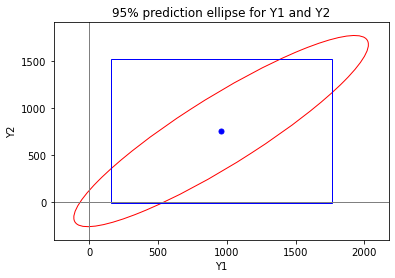

In [29]:
fig, ax = plt.subplots()

e = get_cov_ellipse(Sigma_hat, y_hat[0], np.sqrt(critical_value*(n/(n-r-1))), edgecolor='red', facecolor='None')
r = simultaneous_ci_2d(IC1, IC2, ec ='blue', fc='None')
ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)
ax.scatter(y_hat[0][0], y_hat[0][1], c='blue', s=25)
ax.add_patch(e)
ax.add_patch(r)
ax.set_title("95% prediction ellipse for Y1 and Y2")
ax.set_xlabel('Y1')
ax.set_ylabel('Y2')

plt.show()

Ta có thể thấy rằng phạm vi của từng biến phản hồi khi xét riêng lẻ nhỏ hơn so với hình ellipse. Hình ellipse vẫn chứa điểm **0** trong khi từng biến phản hồi riêng lẻ thì chỉ có biến thứ 2 là có chứa 0. Điều này nói lên được, tổng mức TCAD trong huyết tương (TOT) luôn có, lượng amitriptyline có trong mức TCAD trong huyết tương vẫn xuất hiện nhưng khả năng lại kém hơn 1 ít do tồn tại giá trị 0 trong khoảng dự đoán 95%. Hơn nữa, vẫn có trường hợp không có tác dụng phụ khi xét cả 2 biến phản hồi với độ tin cậy 95% do hình ellipse dự đoán 95% vẫn chứa **0**.
